# DAS Noise2Noise
Apply trained model to semi-synthetic data. 

Notebook steps: 
- [Load Packages and Scripts](#load_packages)
- [Set Input Data Path and Name, Display, and Export Parameters](#set_param)
- [Load Model](#load_model)
- [Load Data](#load_data)
- [Apply Denoising](#apply_denoising)
- [Compute Signal to Noise Ratio](#compute_SNR)


<a id=load_packages></a>
## Load Packages and Scripts

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import signal

In [2]:
import tensorflow as tf
from tensorflow.keras.models import *
# Tensorflow version
print('TensorFlow version:',tf.__version__)
# Set gpu memory if gpu is available
gpu = tf.config.list_physical_devices('GPU') # Check GPU available
print(gpu)
if gpu: 
    tf.config.experimental.set_memory_growth(gpu[0], True)

TensorFlow version: 2.11.0
[]


Import functions for data loading and signal to noise computations

In [3]:
# Import local scripts
from Utils.RP_Proc import fCalcFrameSNR, fCalcSNR2DFrame
from Utils.string_manip import find_str_between
from Utils.apply_nn import fDenoiseDAS

In [4]:
# Function for loading data
def load_variable(filename):
    f = open(filename,'rb')
    r = pickle.load(f)
    f.close()
    return r

<a id=set_param></a>
## Set Input Data Path and Name, Display, and Export Parameters

In [5]:
# Input data
data_path = r'Data\SemiSynthetic'
dt = 0.001 
data_path

'Data\\SemiSynthetic'

In [6]:
# Plot parameters
plt.rc('axes',labelsize=14)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)
interpolation_opt = 'sinc'
c_map = 'seismic'
v_max=5

In [7]:
# Optional pre-processing steps
apply_detrend = False
apply_ringDownRemoval = False

<a id=load_model></a>
## Load Model

In [8]:
model_path = 'Models\\N2N_LowPowerSourceTest_30ep_v10_patch128x96_dgtarget_fliplr.h5'
dasn2n = load_model(model_path) # DAS-N2N

In [9]:
dasn2n.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 96)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 128, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 96, 24)  240         ['reshape[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 96, 24)  0           ['conv2d[0][0]']                 
                                                                                              

<a id=load_data></a>
## Load Data

In [10]:
noisy_data = load_variable(os.path.join(data_path,'D_train_ini_Otway.txt'))
clean_data = load_variable(os.path.join(data_path,'D_train_clean_multipled_Otway.txt'))
noise_data = load_variable(os.path.join(data_path,'D_train_noise_Otway.txt'))

In [11]:
# Noisy shot gather
D = noisy_data
D.shape

(512, 256)

In [12]:
# Clean shot gather
D_clean = clean_data
D_clean.shape

(512, 256)

In [13]:
# Added noise
D_noise = noise_data
D_noise.shape

(512, 256)

<a id=apply_denoising></a>
## Apply Denoising

In [14]:
%%time
st_array_out = fDenoiseDAS(D, dasn2n, 
                           apply_detrend=apply_detrend, apply_ringDownRemoval=apply_ringDownRemoval)

Extracting 45 patches
wHann_submatrices[128, 96]
(1, 640, 288)
Wall time: 463 ms


In [15]:
D.shape

(512, 256)

In [16]:
st_array_out.shape

(512, 256)

<a id=psd></a>
## Power Spectral Density

In [17]:
def spectral_density(strr_in, dt):
    n_time = strr_in.shape[0]
    f,Pxx = signal.welch(strr_in, fs = 1/dt, axis = 0, detrend = 'constant', nperseg = int(n_time/2))
    Px = np.mean(Pxx,axis=1)
    Px = np.sqrt(Px)
    return f, Px

In [18]:
f, Px_noisy = spectral_density(D, dt) #input
f, Px_clean = spectral_density(D_clean, dt) #clean
f, Px_denoised = spectral_density(st_array_out, dt) #denoised
f, Px_noise = spectral_density(D-st_array_out, dt) #removed noise
f, Px_noise_rec = spectral_density(D_noise, dt) #noise
f, Px_diff = spectral_density(D_clean-st_array_out, dt) #diff

<a id=compute_SNR></a>
## Compute Signal to Noise Ratio

SNR frame values

In [19]:
maxlag = 0.1 #(in s)
percent = 30;
ch_start_display = 0
snr_frame_clean = fCalcFrameSNR(D_clean[:,ch_start_display:],percent,np.ceil(maxlag/dt).astype(int))
snr_frame_in = fCalcFrameSNR(D[:,ch_start_display:],percent,np.ceil(maxlag/dt).astype(int))
snr_frame_out = fCalcFrameSNR(st_array_out[:,ch_start_display:],percent,np.ceil(maxlag/dt).astype(int))
snr_frame_noise = fCalcFrameSNR(st_array_out[:,ch_start_display:]-D[:,ch_start_display:],percent,np.ceil(maxlag/dt).astype(int))

In [20]:
print(snr_frame_clean, snr_frame_in, snr_frame_out, snr_frame_noise)

13.930498970938304 2.097858821064829 10.889886446142647 1.9652737355185477


SNR sections

In [21]:
%%time
window = 30
snr_clean = fCalcSNR2DFrame(D_clean[:,ch_start_display:],window)
snr_in = fCalcSNR2DFrame(D[:,ch_start_display:],window)
snr_out = fCalcSNR2DFrame(st_array_out[:,ch_start_display:],window)
snr_noise = fCalcSNR2DFrame(st_array_out[:,ch_start_display:]-D[:,ch_start_display:],window)

Wall time: 4.27 s


## Figures Paper

In [22]:
fig_paper = True

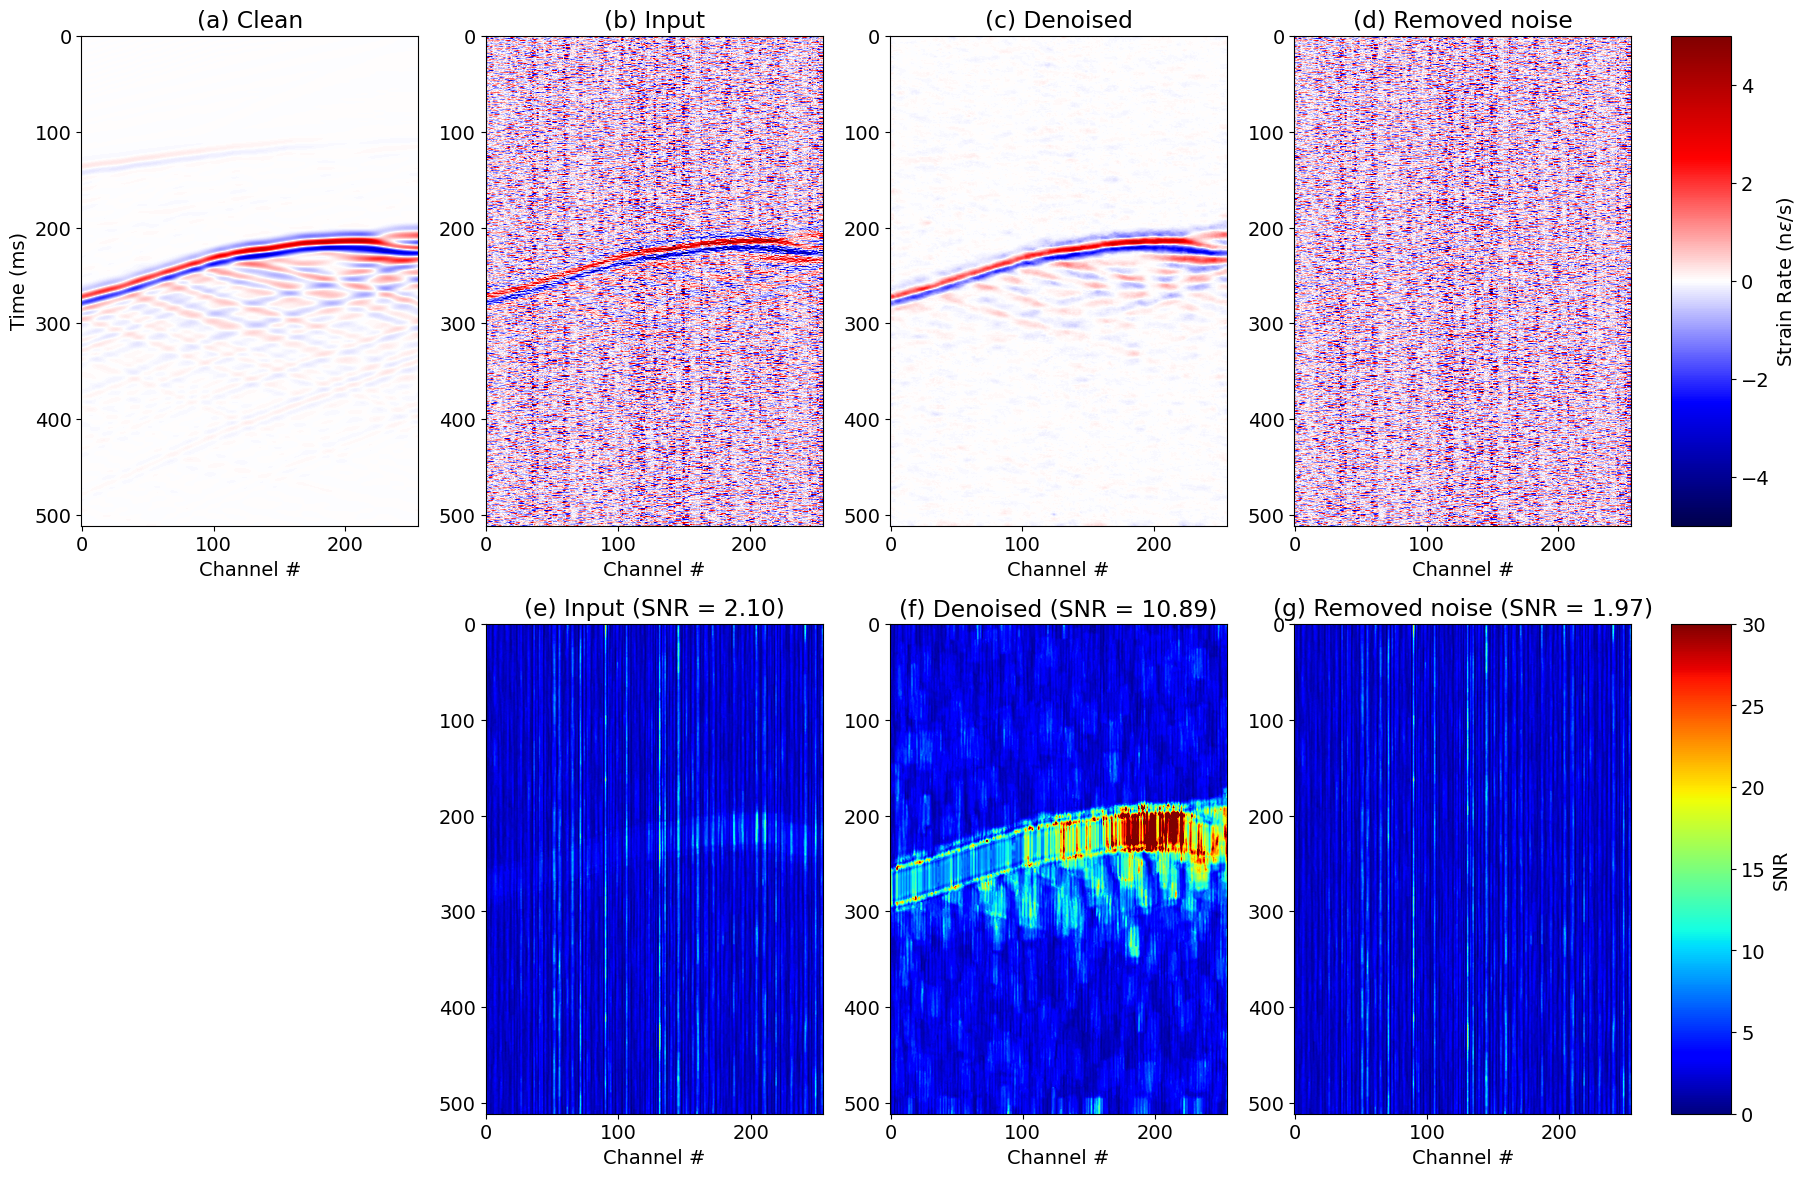

In [23]:
if fig_paper:
    fig, axs = plt.subplots(2,4,figsize=(20,14))
    ch_start_display=0
    ch_end_display=st_array_out.shape[1]
    t_start_display=0
    t_end_display=st_array_out.shape[0]
    v_max=5
    #-- Row 1
    axs[0,0].imshow(D_clean[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                  interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                  vmin=-v_max, vmax=v_max)
    axs[0,0].set(title='(a) Clean', xlabel='Channel #', ylabel='Time (ms)')
    axs[0,1].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                    interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                    vmin=-v_max, vmax=v_max)
    axs[0,1].set(title='(b) Input', xlabel='Channel #')
    axs[0,2].imshow(st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                    interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                    vmin=-v_max, vmax=v_max)
    axs[0,2].set(title='(c) Denoised', xlabel='Channel #')
    im = axs[0,3].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                        interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                        vmin=-v_max, vmax=v_max)
    axs[0,3].set(title='(d) Removed noise', xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.53, 0.03, 0.35])
    fig.colorbar(im, cax=cbar_ax, label='Strain Rate (n$\epsilon$/s)')
    #-- Row 2
    v_snr = 30
    axs[1,0].set_visible(False)
    axs[1,1].imshow(snr_in[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                    interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax = v_snr)
    axs[1,1].set(title='(e) Input (SNR = {:.02f})'.format(snr_frame_in), xlabel='Channel #')
    pcm = axs[1,2].imshow(snr_out[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                          interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax = v_snr)
    axs[1,2].set(title='(f) Denoised (SNR = {:.02f})'.format(snr_frame_out), xlabel='Channel #')
    im2 = axs[1,3].imshow(snr_noise[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                         interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax = v_snr)
    axs[1,3].set(title='(g) Removed noise (SNR = {:.02f})'.format(snr_frame_noise), xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax2 = fig.add_axes([0.92, 0.11, 0.03, 0.35])
    fig.colorbar(im2, cax=cbar_ax2, label='SNR')
    plt.show()

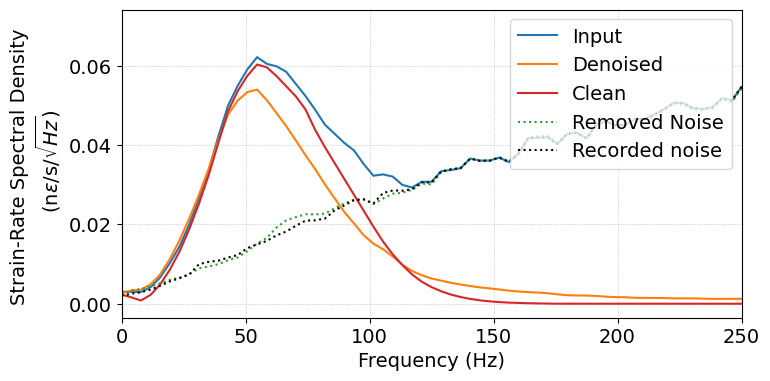

In [24]:
if fig_paper:
    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    ax.plot(f, Px_noisy, label='Input')
    ax.plot(f, Px_denoised, label='Denoised')
    ax.plot(f, Px_clean, label='Clean', color='tab:red')
    ax.plot(f, Px_noise, ':', label='Removed Noise')  
    ax.plot(f, Px_noise_rec, 'k:', label='Recorded noise')
    ax.set(xlabel='Frequency (Hz)', xlim=[0,250],
           ylabel='Strain-Rate Spectral Density \n (n$\epsilon$/s/$\sqrt{Hz}$)', 
           xscale='linear', yscale='linear')
    ax.legend(loc='upper right')
    ax.grid(which='both')
    plt.show()